# 02750 HW2

### Anushka Sinha (anushka3)

#### Imports

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
import random
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from numpy.linalg import norm

# To ignore all warnings:
warnings.filterwarnings('ignore')

#### Data

In [29]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv("iris/iris.data", header=None, names=column_names)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
label_encoder = LabelEncoder()
data['species_encoded'] = label_encoder.fit_transform(data['species'])
data = data.drop(columns=['species'])
data_array = data.to_numpy()

In [30]:
random_seeds = []
for i in range(10):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 19, 6, 77, 40, 60, 34, 22, 86, 80]

#### Cross fold validation 

In [31]:
def run_cross_fold_validation(model, train_X, train_y, seed):
    
    """ 
    Split your training data at that round into 5 different sets of equal size (or as equal as they can be). 
    Train a model using 4 of the 5 sets. Assess that model on the remaining set. 
    Continue this process until each set has been used for assessment once. 
    Add up the errors from all 5 folds and divide by the total number of observed instances. 
    This will yield an average error that will not be severely biased by imbalances in the fold sizes. 
    This will give you a good estimate of the model performance given the data you have available to you at that round. 
    This will not necessarily give you an estimate of generalization performance
  """
    # Initialize KFold with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    fold_accuracies = []

    for train_idx, test_idx in kf.split(train_X):
        # Split the data into training and testing sets for this fold
        X_train_fold, X_test_fold = train_X[train_idx], train_X[test_idx]
        y_train_fold, y_test_fold = train_y[train_idx], train_y[test_idx]

        # Train a model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the testing fold
        y_pred_fold = model.predict(X_test_fold)

        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy) 

    # Calculate average error across all folds
    avg_acc = sum(fold_accuracies) / len(fold_accuracies)
    return avg_acc


## Exercsie 1b Query By Committee

In [32]:
def hard_vote_entropy(pool_X, pool_y, committee_members):
    predictions_pool_X = []
    for model in committee_members:
        y_pred = model.predict(pool_X)
        predictions_pool_X.append(y_pred)
    predictions_pool_X = np.array(predictions_pool_X)
    
    counts_setosa = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_versicolor = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_virginica = np.zeros(len(predictions_pool_X[0]), dtype=int)
    
    # Preidction counts for every label
    for pred in predictions_pool_X:
        for instance, val in enumerate(pred): 
            if val == 0:
                counts_setosa[instance] += 1
            elif val == 1:
                counts_versicolor[instance] += 1   
            elif val == 2:
                counts_virginica[instance] += 1        
    
    HVE_scores = [-1, -math.inf]
    for instance in range(len(counts_setosa)):
        if counts_setosa[instance] != 0:
            first_term = (counts_setosa[instance]/len(committee_members)) * math.log((counts_setosa[instance]/len(committee_members)), 2)
        else:
            first_term = 0
        if counts_versicolor[instance] != 0:
            second_term = (counts_versicolor[instance]/len(committee_members)) * math.log((counts_versicolor[instance]/len(committee_members)), 2)
        else:
            second_term = 0
        if counts_virginica[instance] != 0:
            third_term = (counts_virginica[instance]/len(committee_members)) * math.log((counts_virginica[instance]/len(committee_members)), 2)
        else:
            third_term = 0
        score = -(first_term + second_term + third_term)
        # Return the index of the instance with the highest hard vote entropy
        if score > HVE_scores[1]:
            HVE_scores[0] = instance
            HVE_scores[1] = score
    return HVE_scores[0]
    

In [33]:
def QBC(dataset, seed):
    cross_fold_performance = []

    # Take initial 20% data (random observations)
    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :4], sample_data[:, 4]  # Slicing first four columns
    remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]  # Slicing first four columns

    # Initialize committee members
    committee = [RandomForestClassifier() for _ in range(10)]
    for model in committee:
        model.fit(sample_data_X, sample_data_y)

    base_learner_model = RandomForestClassifier(random_state=None)

    # Run until all observations are added:
    while len(remaining_data) > 0:
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
    
        # Select an instance to add = hard_vote_entropy()
        instance_to_add = hard_vote_entropy(remaining_data_X, remaining_data_y, committee)

        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]

        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)

        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]
        
        # Retrain the committee members on the updated training set
        for model in committee:
            model.fit(sample_data_X, sample_data_y)

    return cross_fold_performance


In [34]:
# Running QBC 
cross_fold_accuracies_QBC = []

for seed in tqdm(random_seeds):
    cv_acc = QBC(data_array, seed)
    cross_fold_accuracies_QBC.append(cv_acc)

avg_acc_QBC = np.mean(cross_fold_accuracies_QBC, axis=0)
std_acc_QBC = np.std(cross_fold_accuracies_QBC, axis=0)

100%|██████████| 10/10 [16:09<00:00, 96.90s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


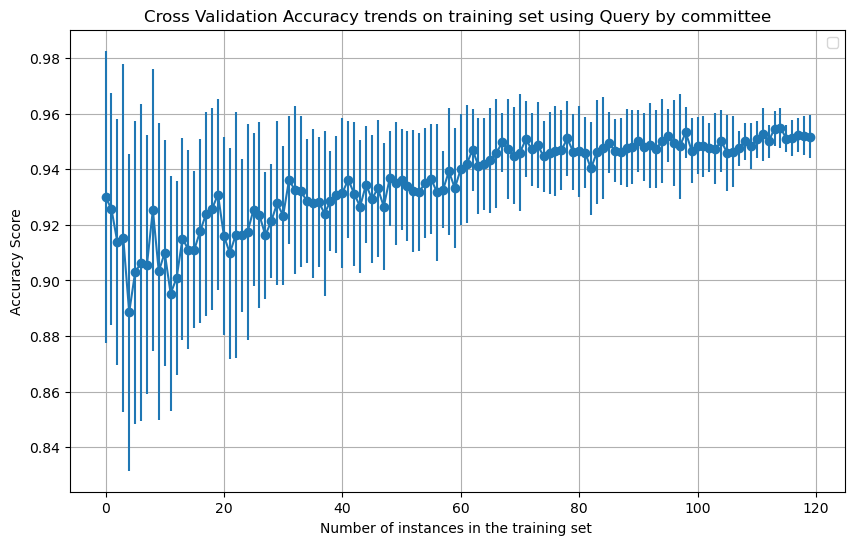

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x_values_QBC = list(range(len(cv_acc)))

plt.errorbar(x_values_QBC, avg_acc_QBC, yerr=std_acc_QBC, fmt='-o', linestyle='-')
plt.title('Cross Validation Accuracy trends on training set using Query by committee')
plt.xlabel('Number of instances in the training set ')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


## Exercsie 1c Minimization of Expected risk

In [36]:
def calc_expected_risk(model, old_train_X, old_train_y, unlabeled_pool_X, old_probs):
    labels = [0., 1., 2.]
    # Store (index, label) as key and probabilities as values
    probabilities = dict()

    for index, instance in enumerate(unlabeled_pool_X):
        # Delete this instance from the unlabeled pool
        updated_unlabeled_pool_X = np.delete(unlabeled_pool_X, index, axis=0)
        if updated_unlabeled_pool_X.shape[0] == 0:
            # Skip this iteration if there are no samples left
            continue
        # Add this instance to the train set
        new_train_X = np.append(old_train_X, instance.reshape(1, -1), axis=0)
        # Loop through every label for this instance
        for label in labels:
            # Train the model on the updated train_X and train_y
            new_train_y = np.append(old_train_y, np.array([label]), axis=0)
            model.fit(new_train_X, new_train_y)
            # Get probabilities for the every instance except the instance we are working with 
            probs = model.predict_proba(updated_unlabeled_pool_X)
            probs = np.insert(probs, index, 1.0, axis = 0)
            max_probs = np.max(probs, axis=1)
            # Store the probabilities obtained for this specific pair of instance and label
            probabilities[(index, label)] = max_probs
    
    all_ER = []  
    for i, pred in enumerate(old_probs):
        summand = 0
        for j in range(len(pred)):
            key = (i, j)
            val_class = sum(1 - row for row in probabilities[key])
            summand += val_class * pred[j]
        all_ER.append(summand)

    query_idx = np.argmin(all_ER)
    return query_idx


In [37]:
def minimizing_expected_risk(dataset, seed):
    cross_fold_performance = []

    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :-1], sample_data[:, -1]
    remaining_data_X, remaining_data_y = remaining_data[:, :-1], remaining_data[:, -1]

    # Initialize and fit the model
    base_learner_model = RandomForestClassifier(n_estimators = 5, random_state=42)
    base_learner_model.fit(sample_data_X, sample_data_y)
   
    # Run until all observations are added:
    while len(remaining_data) > 1:
       
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
        
        # Select an instance to add = hard_vote_entropy()
        probs = base_learner_model.predict_proba(remaining_data_X)
        instance_to_add = calc_expected_risk(base_learner_model, sample_data_X, sample_data_y, remaining_data_X, probs)
        
        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        
        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :-1], remaining_data[:, -1]
        remaining_indices = list(range(len(remaining_data_X)))
        
    return cross_fold_performance # length 120

In [38]:
cross_fold_accuracies_MER = []

for seed in tqdm(random_seeds):
    cv_acc = minimizing_expected_risk(data_array, seed)
    cross_fold_accuracies_MER.append(cv_acc)
  
avg_acc_MER = np.mean(cross_fold_accuracies_MER, axis=0)
std_acc_MER = np.std(cross_fold_accuracies_MER, axis=0)


100%|██████████| 10/10 [11:44<00:00, 70.41s/it]


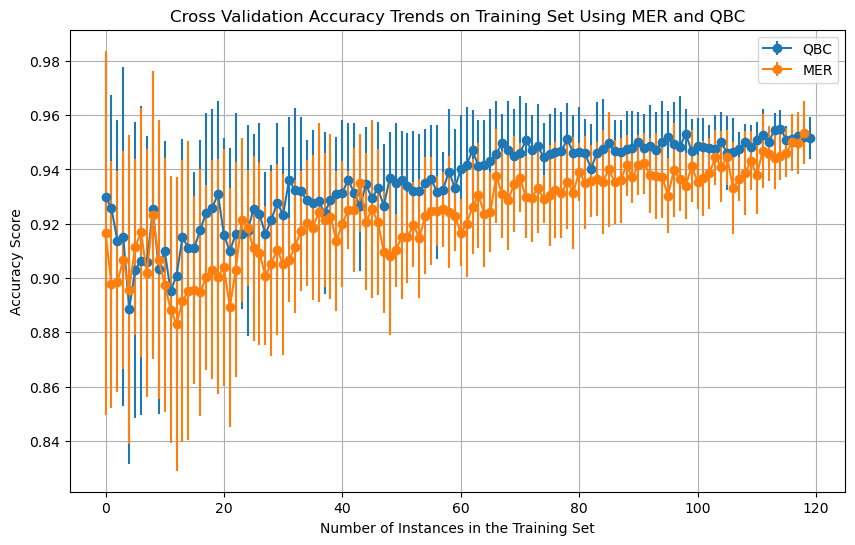

In [39]:
plt.figure(figsize=(10, 6))
x_values_MER = list(range(len(cv_acc)))


# Plotting
plt.errorbar(x_values_QBC[:120], avg_acc_QBC, yerr=std_acc_QBC, fmt='-o', linestyle='-', label="QBC")
plt.errorbar(x_values_MER, avg_acc_MER, yerr=std_acc_MER, fmt='-o', linestyle='-', label="MER")
plt.title('Cross Validation Accuracy Trends on Training Set Using MER and QBC')
plt.xlabel('Number of Instances in the Training Set')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

## Exercsie 1d Density-based sampling

In [40]:
def hard_vote_entropy_dbs(pool_X, pool_y, committee_members):
    predictions_pool_X = []
    for model in committee_members:
        y_pred = model.predict(pool_X)
        predictions_pool_X.append(y_pred)
    predictions_pool_X = np.array(predictions_pool_X)
    
    counts_setosa = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_versicolor = np.zeros(len(predictions_pool_X[0]), dtype=int)
    counts_virginica = np.zeros(len(predictions_pool_X[0]), dtype=int)
   
    for pred in predictions_pool_X:
        for instance, val in enumerate(pred): 
            if val == 0:
                counts_setosa[instance] += 1
            elif val == 1:
                counts_versicolor[instance] += 1   
            elif val == 2:
                counts_virginica[instance] += 1        
    
    HVE_scores = np.empty(len(predictions_pool_X[0]))
    for instance in range(len(counts_setosa)):
        if counts_setosa[instance] != 0:
            first_term = (counts_setosa[instance]/len(committee_members)) * math.log((counts_setosa[instance]/len(committee_members)), 2)
        else:
            first_term = 0
        if counts_versicolor[instance] != 0:
            second_term = (counts_versicolor[instance]/len(committee_members)) * math.log((counts_versicolor[instance]/len(committee_members)), 2)
        else:
            second_term = 0
        if counts_virginica[instance] != 0:
            third_term = (counts_virginica[instance]/len(committee_members)) * math.log((counts_virginica[instance]/len(committee_members)), 2)
        else:
            third_term = 0
        score = -(first_term + second_term + third_term)
        np.append(HVE_scores, score)
   
    return HVE_scores
    

In [41]:
def get_average_similarity(instance, hard_vote_entropy_scores, unlabeled_pool_X):
    cosine_similarity = 0
    for i, val in enumerate(unlabeled_pool_X):
        if i != instance:
            cosine_similarity += np.dot(instance,i)/(norm(instance)*norm(i))
    score = hard_vote_entropy_scores[instance]*(cosine_similarity/len(unlabeled_pool_X))
    return score


In [42]:
def get_instance_to_add(unlabeled_pool_X, hard_vote_entropy_scores):
    ID_scores = [-1, -math.inf]
    for i, val in enumerate(unlabeled_pool_X):
        score = get_average_similarity(i, hard_vote_entropy_scores, unlabeled_pool_X)
        if score > ID_scores[1]:
            ID_scores[0] = i
            ID_scores[1] = score
    return ID_scores[0]

In [43]:
def DBS(dataset, seed):
    cross_fold_performance = []

    # Take initial 20% data (random observations)
    sample_data, remaining_data = train_test_split(dataset, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :4], sample_data[:, 4]  # Slicing first four columns
    remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]  # Slicing first four columns

    # Initialize committee members
    committee = [RandomForestClassifier() for _ in range(10)]
    for model in committee:
        model.fit(sample_data_X, sample_data_y)

    base_learner_model = RandomForestClassifier(random_state=None)
    # Run until all observations are added:
   
    while len(remaining_data) > 0:
        cv_accuracy = run_cross_fold_validation(base_learner_model, sample_data_X, sample_data_y, seed)
        cross_fold_performance.append(cv_accuracy)
    
        # Select an instance to add = hard_vote_entropy()
        
        HVE_scores = hard_vote_entropy_dbs(remaining_data_X, remaining_data_y, committee)
        instance_to_add = get_instance_to_add(remaining_data_X, HVE_scores)

        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[instance_to_add], remaining_data_y[instance_to_add]

        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)

        # Remove the queried instance from the pool
        remaining_data = np.delete(remaining_data, instance_to_add, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :4], remaining_data[:, 4]
       
        # Retrain the committee members on the updated training set
        for model in committee:
            model.fit(sample_data_X, sample_data_y)

    return cross_fold_performance

In [44]:
cross_fold_accuracies_DBS = []

for seed in tqdm(random_seeds):
    cv_acc = DBS(data_array, seed)
    cross_fold_accuracies_DBS.append(cv_acc)

# acc = list(cross_fold_accuracies.values())
avg_acc_DBS = np.mean(cross_fold_accuracies_DBS, axis=0)
std_acc_DBS = np.std(cross_fold_accuracies_DBS, axis=0)

100%|██████████| 10/10 [16:40<00:00, 100.00s/it]


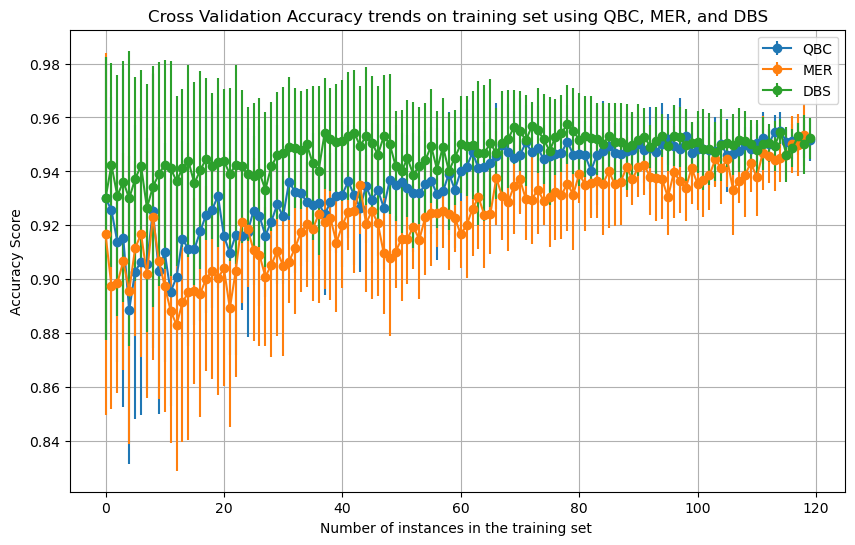

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# average_training_sizes = np.mean(training_sizes, axis=0)
x_values_DBS = list(range(len(cv_acc)))

plt.errorbar(x_values_QBC, avg_acc_QBC, yerr=std_acc_QBC, fmt='-o', linestyle='-', label= "QBC")
plt.errorbar(x_values_MER, avg_acc_MER, yerr=std_acc_MER, fmt='-o', linestyle='-', label="MER")
plt.errorbar(x_values_DBS, avg_acc_DBS, yerr=std_acc_DBS, fmt='-o', linestyle='-', label="DBS")
plt.title('Cross Validation Accuracy trends on training set using QBC, MER, and DBS')
plt.xlabel('Number of instances in the training set ')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 1e

In [46]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data_df = pd.read_csv("iris/iris.data", header=None, names=column_names)
shuffled_data = shuffle(data_df, random_state=42)

#### Passive Learning

In [47]:
def classification_passive_learning(d, seed):
    # Store average cross fold validation accuracy
    cross_fold_acc = [] 

    d = shuffle(data, random_state=seed)

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
    
    # Run the loop while the sample_data includes 100% of the original data
    while len(remaining_data) > 0:
        # Store accuracy from individual fold 
        fold_acc = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            model = RandomForestClassifier(random_state=None)
            model.fit(features_train, labels_train)
            y_pred = model.predict(features_test)
            acc = accuracy_score(labels_test, y_pred)
            fold_acc.append(acc)
            
        # Get the average cross fold accuracy on the training data
        avg_cross_fold_acc = np.mean(fold_acc)
        cross_fold_acc.append(avg_cross_fold_acc)


        # Move one instance from test data to training data 
        instance_to_add = remaining_data.sample(n=1)
        sample_data = pd.concat([sample_data, instance_to_add], ignore_index=True) 
        remaining_data = remaining_data.drop(instance_to_add.index)
        

    return cross_fold_acc

In [48]:
# Running Passive Learning
cv_acc_passive = [] 

for seed in tqdm(random_seeds):
    cv_acc = classification_passive_learning(shuffled_data, seed)
    cv_acc_passive.append(cv_acc)

avg_acc_passive = np.mean(cv_acc_passive, axis=0)
std_acc_passive = np.std(cv_acc_passive, axis=0)


100%|██████████| 10/10 [05:15<00:00, 31.53s/it]


#### Active Learning (Uncertainty Sampling)

In [49]:
def get_entropies(labels_probs):
    entropies = [] 
    epsilon = 0.0001
    for i in labels_probs:
        prod = i * np.log2(i+epsilon)
        entropies.append(-np.sum(prod))
    return entropies
        

In [50]:
import numpy as np

def classification_active_learning(d, seed):
    cross_fold_acc = [] 

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]

    # Run the loop until the sample data includes 100% of the original data 
    while len(remaining_data) > 0:
        # Store accuracy score from individual fold
        fold_acc = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            model = RandomForestClassifier(random_state=None)
            model.fit(features_train, labels_train)
            y_pred = model.predict(features_test)
            acc = accuracy_score(labels_test, y_pred)
            fold_acc.append(acc)
            
        # Get the average of the fold accuracies on the training data
        avg_cross_fold_acc = np.mean(fold_acc)
        cross_fold_acc.append(avg_cross_fold_acc)

        # Training a model on the current sample data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)

        # Predicting class probabilities for the remaining data
        remaining_data_X = remaining_data.iloc[:, :-1]
        labels_probabilities = np.array(mod.predict_proba(remaining_data_X)) # 120 rows, 3 classes (columns)

        # Calculating entropies
        entropies = get_entropies(labels_probabilities)

        # Selecting the point with the highest entropy to add to the sample data 
        highest_entropy_index = np.argmax(entropies)
        sample_to_add = remaining_data.iloc[[highest_entropy_index]]

        # Adding the selected instance to the sample data
        sample_data = pd.concat([sample_data, sample_to_add], ignore_index=True)
        sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        # Remove that point from the remaining data
        remaining_data = remaining_data.drop(sample_to_add.index)
        
    return cross_fold_acc


In [51]:
# Running Active Learning 
cv_acc_active = []

for seed in tqdm(random_seeds):
    cv_acc = classification_active_learning(shuffled_data, seed)
    cv_acc_active.append(cv_acc)

avg_acc_active = np.mean(cv_acc_active, axis=0)
std_acc_active = np.std(cv_acc_active, axis=0)


100%|██████████| 10/10 [06:30<00:00, 39.03s/it]


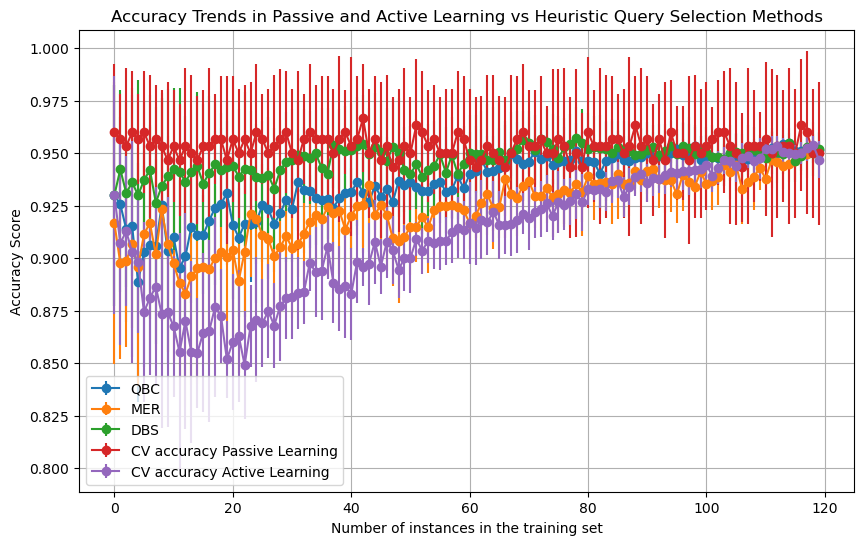

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x_values_passive_active = list(range(len(cv_acc)))

plt.errorbar(x_values_QBC, avg_acc_QBC, yerr=std_acc_QBC, fmt='-o', linestyle='-', label= "QBC")
plt.errorbar(x_values_MER, avg_acc_MER, yerr=std_acc_MER, fmt='-o', linestyle='-', label="MER")
plt.errorbar(x_values_DBS, avg_acc_DBS, yerr=std_acc_DBS, fmt='-o', linestyle='-', label="DBS")
plt.errorbar(x_values_passive_active, avg_acc_passive, yerr=std_acc_passive, label='CV accuracy Passive Learning', fmt='-o',linestyle='-')
plt.errorbar(x_values_passive_active, avg_acc_active, yerr=std_acc_active, label='CV accuracy Active Learning', fmt='-o', linestyle='-')
plt.title('Accuracy Trends in Passive and Active Learning vs Heuristic Query Selection Methods')
plt.xlabel('Number of instances in the training set')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()
